# Calculate travel times

This stage computes the travel times from all the points of a three-dimensional grid to each seismic station. The travel times grid allows for shifting the data according to every tested point source point in the beamforming response calculation.

This tutorial utilizes the `PyKonal` package to compute travel times in a space-dependant velocity medium. The package documentation and installation procedure are described in the [PyKonal package documentation](https://github.com/malcolmw/pykonal). Please acknowledge [White et al. (2020)](https://pubs.geoscienceworld.org/ssa/srl/article-abstract/91/4/2378/586804/PyKonal-A-Python-Package-for-Solving-the-Eikonal?redirectedFrom=fulltext) if using the package.

In [1]:
import glob
import h5py
import numpy as np
import obspy
import os
import pandas as pd
import pykonal
import tqdm
import xarray as xr

from matplotlib import pyplot as plt
from pykonal.transformations import geo2sph, sph2geo

## Read velocity model

We downloaded the velocity model of [Karabulut et al. (2011)](https://www.sciencedirect.com/science/article/pii/S0040195111002903?casa_token=wTzEUe0IdicAAAAA:fYbKmGkHHrQfyLicd0lO4Ai451jT6h_yTF6ZZXrvglpw9rXDTVVzWzIWNQ0aFAFbMJ_pU6I) and accessed with `pandas`. The model is given in meters for the depth and in m/s for the speed values. Everything is converted to km for the later compatibility with `pykonal`. 

In [2]:
FILEPATH_VELOCITY = "../data/velocity_model_Karabulut2011.csv"

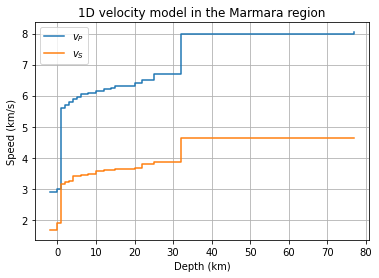

,P,S
depth,,
-2.0,2.900,1.67
0.0,3.000,1.90
1.0,5.600,3.15
2.0,5.700,3.21
3.0,5.800,3.26
4.0,5.900,3.41
5.0,5.950,3.42
6.0,6.050,3.44
8.0,6.100,3.48


In [3]:
SEISMIC_PHASES = ["P", "S"]
COLUMNS = ["depth", "vp", "vs"]

# Read velocity model
velocity_model = pd.read_csv(FILEPATH_VELOCITY, index_col=0)

# Column renaming and filtering
velocity_model.rename(columns={"z_top": "depth"}, inplace=True)
velocity_model.columns = [col.lower() for col in velocity_model.columns]
velocity_model = velocity_model.filter(COLUMNS)
velocity_model.rename(columns={"vp": "P", "vs": "S"}, inplace=True)

# Convert everything to kilometers or km/s
velocity_model *= 1e-3
velocity_model = velocity_model.set_index("depth")

# Plot
ax = velocity_model.plot(drawstyle="steps-post")
ax.set_ylabel("Speed (km/s)")
ax.set_xlabel("Depth (km)")
ax.set_title("1D velocity model in the Marmara region")
ax.legend([rf"$v_{phase}$" for phase in SEISMIC_PHASES])
ax.grid()
plt.show()

# Show table
velocity_model


## Interpolate velocity model at depth

We calculate the travel times on a finer grid than the model grid, so we need to interpolate the model. We do so while keeping the layer aspect of the model (last-value constant interpolation).

In [4]:
# The surface extents are in degrees, the depth positive downwards and in km
WEST, EAST, SOUTH, NORTH, DOWN, UP = 30.20, 30.45, 40.60, 40.76, 30.0, -2.0
GRID_SIZE = N_DEPTH, N_LAT, N_LON = 50, 20, 30

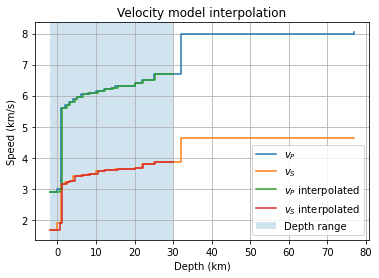

In [5]:
# Interpolate at depth
depths = np.linspace(UP, DOWN, N_DEPTH)
velocity_model_interp = velocity_model.reindex(depths, method="ffill")

# Plot
ax = velocity_model.plot(drawstyle="steps-post")
velocity_model_interp.plot(drawstyle="steps-post", ax=ax)
ax.set_ylabel("Speed (km/s)")
ax.set_xlabel("Depth (km)")
ax.axvspan(DOWN, UP, alpha=0.2)
ax.legend(
    [
        r"$v_P$",
        r"$v_S$",
        r"$v_P$ interpolated",
        r"$v_S$ interpolated",
        "Depth range",
    ]
)
ax.set_title("Velocity model interpolation")
ax.grid()


## Velocity grid in 3D

Because the overall package works in full three-dimensional coordinates, we tile the velocity model into a three-dimensional one. We do that by replicating the 1D along longitude and latitude dimensions with `xarray`.

In [6]:
# Convert to xarray
velocities = velocity_model_interp.to_xarray()

# Longitude and latitude extents
longitudes = np.linspace(WEST, EAST, N_LON)
latitudes = np.linspace(SOUTH, NORTH, N_LAT)
spatial_extension = {"latitude": latitudes, "longitude": longitudes}
velocities = velocities.assign_coords(spatial_extension)
dimensions = list(velocities.dims)

# Assign tiled velocity
for phase in SEISMIC_PHASES:
    velocity = velocities[phase].to_numpy()
    velocity = np.tile(velocity[:, None, None], [N_LAT, N_LON])
    velocities = velocities.assign({phase: (dimensions, velocity)})

# Show table
velocities

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 20, longitude: 30)
Coordinates:
  * depth      (depth) float64 -2.0 -1.347 -0.6939 -0.04082 ... 28.69 29.35 30.0
  * latitude   (latitude) float64 40.6 40.61 40.62 40.63 ... 40.74 40.75 40.76
  * longitude  (longitude) float64 30.2 30.21 30.22 30.23 ... 30.43 30.44 30.45
Data variables:
    P          (depth, latitude, longitude) float64 2.9 2.9 2.9 ... 6.7 6.7 6.7
    S          (depth, latitude, longitude) float64 1.67 1.67 1.67 ... 3.85 3.85

## Station coordinates

**Note:** we use the inventory handler of obspy to gather the station coordinates. The `.get_coordinates()` method of the `inventory` object needs a `seed_id` to capture the response or coordinates of a given stream at a given station state in time. This cell gets the first entry of that inventory, noting that for more advanced application this should be handled with care.

In [7]:
stations_coords = dict()

# Extract from inventory files
for filepath_inventory in glob.glob("../data/*xml"):

    # Get inventory and corresponding station code from filename
    inventory = obspy.read_inventory(filepath_inventory)
    station_code, _ = os.path.splitext(os.path.basename(filepath_inventory))

    # Loading coordinates from the inventory requires a seed_id (likely because
    # of the potential sensor changes over time). Because we did not load any
    # stream here, and we are quite confident with this example that the
    # station coordinates do not change over a day, we load the first available
    # seed id. Note that sometimes a sensor can come with different coordinates
    # for different channels (boreholes for instance).
    seed_id = inventory.get_contents()["channels"][0]

    # Get coordinates from that seed id.
    stations_coords[station_code] = inventory.get_coordinates(seed_id)
    station_depth = 1e-3 * stations_coords[station_code]["elevation"]
    stations_coords[station_code]["depth"] = station_depth

## Show model and stations

Give an overview of the input data.

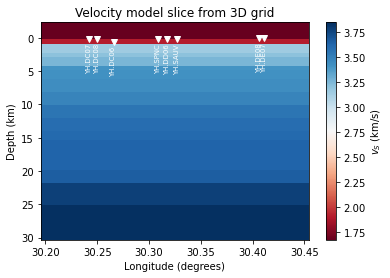

In [8]:
SEISMIC_PHASE = "S"

# Select slice at first latitude index
velocities_slice = velocities[SEISMIC_PHASE].isel(latitude=0)
img = velocities_slice.plot.imshow(cmap="RdBu", add_colorbar=False)

# Labels
ax = plt.gca() 
ax.invert_yaxis()
ax.set_xlabel("Longitude (degrees)")
ax.set_ylabel("Depth (km)")
ax.set_title("Velocity model slice from 3D grid")
cb = plt.colorbar(img)
cb.set_label(rf"$v_{SEISMIC_PHASE}$ (km/s)")

# Add stations
for station, coordinate in stations_coords.items():
    xy = coordinate["longitude"], coordinate["depth"]
    text = f"{station}  "
    plt.plot(*xy, "wv")
    plt.text(
        *xy, text, rotation=90, ha="center", va="top", c="w", size="x-small"
    )


## Calculate travel times and save

The travel times are calculated for every station with the Eikonal solver of the `pykonal` package. The travel times are then saved into a `h5` file for later use. 

**Warning**: in PyKonal, the convention is latitude, longitude and depth in increasing direction.

In [9]:
FILEPATH_TRAVELTIMES = "../data/travel_times.nc"
STATION_ENTRIES = ["station_latitude", "station_longitude", "station_depth"]

# Initiliaze travel times
station_names = list(stations_coords)
travel_times = velocities.copy()
travel_times = travel_times.assign_coords({"station": station_names})
travel_times = travel_times.drop_vars(SEISMIC_PHASES)

# Assign station coordinates to travel times
for coordinate in ("latitude", "longitude", "depth"):
    station_coord = [stations_coords[sta][coordinate] for sta in station_names]
    station_entry = {f"station_{coordinate}": ("station", station_coord)}
    travel_times = travel_times.assign(station_entry)

for phase in SEISMIC_PHASES:

    # Initialize grid
    tt = np.zeros((len(station_names), *velocities[phase].shape))

    # Loop over stations
    progress_bar_iterator = enumerate(travel_times.station)
    for index, station in tqdm.tqdm(
        progress_bar_iterator,
        total=len(station_names),
        desc=f"Travel times for {phase}",
    ):

        coordinates = travel_times[STATION_ENTRIES].sel(station=station)
        coordinates = coordinates.to_array().to_numpy()

        # Solve Eikonal equation
        step_depth = depths[1] - depths[0]
        step_lat = np.deg2rad(latitudes[1] - latitudes[0])
        step_lon = np.deg2rad(longitudes[1] - longitudes[0])
        reference_point = (
            latitudes.max(),
            longitudes.min(),
            depths.max()
        )
        reference_point = geo2sph(reference_point)
        solver = pykonal.solver.PointSourceSolver(coord_sys="spherical")
        solver.velocity.min_coords = reference_point
        solver.velocity.node_intervals = step_depth, step_lat, step_lon
        solver.velocity.npts = N_DEPTH, N_LAT, N_LON
        solver.velocity.values = velocities[phase][::-1]
        solver.src_loc = geo2sph(coordinates)

        # Solve travel times (flip back for depth convention)
        solver.solve()
        tt[index, ...] = solver.tt.values[::-1, ...]

    # Assign to dataset
    var = {phase: (("station", "depth", "latitude", "longitude"), tt)}
    travel_times = travel_times.assign(var)

# Save as h5
travel_times.to_netcdf(FILEPATH_TRAVELTIMES)

# Show how it looks like
travel_times


Travel times for S: 100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


<xarray.Dataset>
Dimensions:            (depth: 50, latitude: 20, longitude: 30, station: 8)
Coordinates:
  * depth              (depth) float64 -2.0 -1.347 -0.6939 ... 28.69 29.35 30.0
  * latitude           (latitude) float64 40.6 40.61 40.62 ... 40.74 40.75 40.76
  * longitude          (longitude) float64 30.2 30.21 30.22 ... 30.44 30.45
  * station            (station) <U7 'YH.DC07' 'YH.DC06' ... 'YH.SPNC' 'YH.SAUV'
Data variables:
    station_latitude   (station) float64 40.67 40.62 40.74 ... 40.75 40.69 40.74
    station_longitude  (station) float64 30.24 30.27 30.25 ... 30.41 30.31 30.33
    station_depth      (station) float64 0.164 0.555 0.162 ... 0.031 0.19 0.17
    P                  (station, depth, latitude, longitude) float64 3.108 .....
    S                  (station, depth, latitude, longitude) float64 5.36 ......

## Show travel times at a given station

The travel times are calculated for every station with the Eikonal solver of the `pykonal` package. The travel times are then saved into a `h5` file for later use.

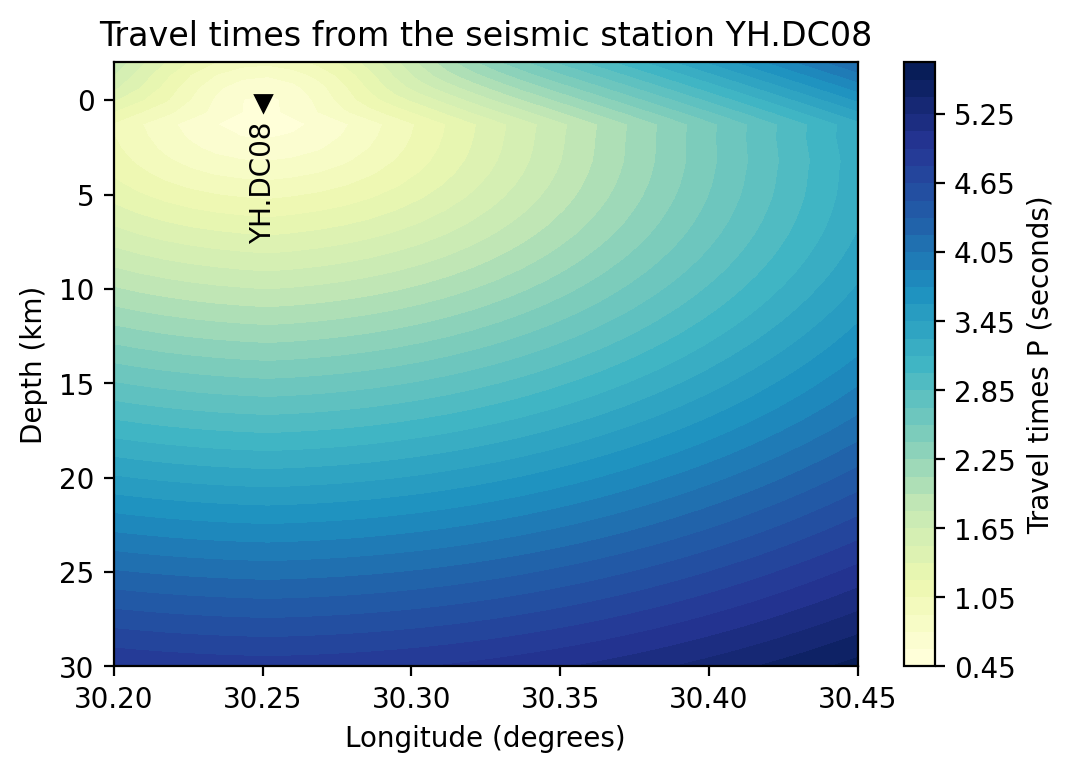

In [10]:
CONTOUR_LEVELS = 40
LONGITUDE_ID = 0
STATION = travel_times.station[2].data
SEISMIC_PHASE = "P"

# Show
fig, ax = plt.subplots()
delays = travel_times[SEISMIC_PHASE].sel(station=STATION).isel(latitude=0)
img = delays.plot.contourf(
    levels=CONTOUR_LEVELS, ax=ax, add_colorbar=False, cmap="YlGnBu", zorder=0
)

# Colorbar
cb = plt.colorbar(img)
cb.set_label(f"Travel times {SEISMIC_PHASE} (seconds)")
cb.ax.set_rasterization_zorder(1.5)

# Station
x = travel_times.station_longitude.sel(station=STATION)
y = travel_times.station_depth.sel(station=STATION)
ax.plot(x, y, "kv")
ax.text(x, y, f"{STATION}  ", rotation="vertical", ha="center", va="top")

ax.invert_yaxis()
ax.set_xlabel("Longitude (degrees)")
ax.set_ylabel("Depth (km)")
ax.set_rasterization_zorder(1)
ax.set_title(f"Travel times from the seismic station {STATION}")

# For rasters display resolution
fig.set_dpi(200)
